In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
import pathlib

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as KL
import voxelmorph as vxm

import nibabel as nib
from tensorflow.keras.models import load_model
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full
from utils import *

# en=[128,128,128,128,128]
# de=[128,128,128,128,128,2]

en=[16,32,64,64,64,64,64]
de=[64,64,64,64,64,32,16,2]

# en=[16,32,64,64,64,128,128]
# de=[128,128,64,64,64,32,16,2]

en=[16,16, 32,32, 64,64,128,128, 256,256]
de=[256,256, 128,128,64,64,32,32,16,16,2]

# en=[16,16, 32,32, 64,64, 64,64, 64, 64,64, 64,64, 64]
# de=[64,64, 64,64, 64, 64,64, 64,64, 64,32,32,16,16,2]
# en=[64,128,256,512]
# de=[512,256,128,64,2]

# en=[64,64,64,64,64]
# de=[64,64,64,64,64,2]

# if args.:
sc=0.8    
tf.get_logger().setLevel('ERROR')
log_dir='logs_feta'
en_str = '_'.join(map(str, en))
de_str = '_'.join(map(str, de))

models_dir = f"models_synth_mom_brain_params_{en_str}_{de_str}_nc_2_bs_1_sc_{sc}"
# print(model_filename)

# models_dir='models_feta_mom_brain_params_'+str(nb_features)+"_nc_2_bs_1"
# models_dir='models_feta_mom_brain_params_128_128_128_128_128'
# checkpoint_path='weights_epoch_1000.h5'
initial_epoch=5000
# models_dir='models_feta_mom_brain_params_'+str(nb_features)+'_nc_'+str(args.nb_conv_per_level)+'_bs_'+str(args.batch_size)
nc=2
bs=2
checkpoint_path=models_dir+'/weights_epoch_'+str(initial_epoch)+'.h5'

data_dir = 'feta_2d/'

feta = pathlib.Path('/autofs/space/bal_004/users/jd1677/synthstrip/feta_2d')
files = list(feta.glob('sub-???/sub-???_dseg.nii.gz'))
label_maps = [np.uint8(f.dataobj) for f in map(nib.load, files)]
labels = np.unique(label_maps)
in_shape = label_maps[0].shape

num_labels = 8
num_shapes = 80

dimx=256
dimy=256

initial_lr=1e-4

warp_max=3
warp_min=.1

nb_levels=5
conv_size=3
num_epochs=50000
num_bg_labels=16
warp_fwhm_min=1
warp_fwhm_max=2

in_shape=(dimx,dimy)
bg_brain = True

image_fwhm_min=20
image_fwhm_max=40
aff_shift=30
aff_rotate=180
aff_shear=0.1
blur_max=3.4
slice_prob=1
crop_prob=1
aff_scale=5


bias_min=0.01
bias_max=0.2
zero_background=0.1

labels_in = range(max(labels) + num_labels + 1)

gen_arg = {
    'in_shape': in_shape,
    'labels_in': labels_in,
    'labels_out': {f: 1 if f in (1, 2, 3, 4, 5, 6, 7) else 2 for f in labels_in},
    'warp_min': warp_min,
    'one_hot':True,
    'axes_flip':True,
    'axes_swap':True,
    'warp_max': warp_max,
    'aff_shift':aff_shift,
    'aff_rotate':aff_rotate,
    'aff_shear':aff_shear,
    'bias_min':bias_min,
    'bias_max':bias_max,
    'aff_scale':aff_scale,
    'up_scale':False,
    'zero_background':zero_background
}

unet_model = vxm.networks.Unet(inshape=(dimx, dimy, 1), nb_features=[en, de], 
                               nb_conv_per_level=2,
                               final_activation_function=tf.nn.softmax)

input_img = Input(shape=(dimx, dimy,1))


unet_model = vxm.networks.Unet(inshape=(dimx, dimy, 1), nb_features=[en, de], 
                               nb_conv_per_level=2,
                               final_activation_function=tf.nn.softmax)

# params = {
#     'shift': None,
#     'rot': None,
#     'scale':5,
#     'up_scale': False,  # Set this to True or False for testing
#     'shear': None,
#     'normal_shift': False,
#     'normal_rot': False,
#     'normal_scale': False,
#     'normal_shear': False,
#     'shift_scale': True,
#     'ndims': 3,
#     'batch_shape': None,
#     'concat': True,
#     'dtype': tf.float32,
#     'seeds': {},
# }

labels_to_image_model = ne.models.labels_to_image_new(
    in_shape=in_shape,
    labels_in=labels_in,
    labels_out={f: 1 if f in (1, 2, 3, 4, 5, 6, 7) else 2 for f in labels_in},
    aff_shift=30,
    aff_rotate=180,
    aff_shear=0.1,
    blur_max=3.4,
    slice_prob=1,
    crop_prob=1,
)

labels_to_image_model = ne.models.labels_to_image_new(**gen_arg)
# labels_to_image_model = ne.models.labels_to_image_new(**gen_arg)

input_img = Input(shape=(dimx, dimy))
generated_img, y = labels_to_image_model(input_img)
print(generated_img.shape,y.shape)

segmentation = unet_model(generated_img)
combined_model = Model(inputs=input_img, outputs=segmentation)
combined_model.add_loss(soft_dice(y, segmentation))
combined_model.compile(optimizer=Adam(learning_rate=initial_lr))


if os.path.exists(checkpoint_path):
    combined_model.load_weights(checkpoint_path)
    print("Loaded weights from the checkpoint and continued training.")
else:
    print(checkpoint_path)
    print("Checkpoint file not found.")



        
# fetal_data, fetal_segmentation_masks = load_data(data_dir)
# X_train, X_test, y_train, y_test = train_test_split(fetal_data, fetal_segmentation_masks, test_size=0.2, random_state=42)

# unet_model = load_model(checkpoint_path)

# train_dice_coefficients = []
# test_dice_coefficients = []


# for i in range(len(X_train)):
#     real_img = X_train[i]
#     seg_img = y_train[i]

#     # Ensure that the input has the correct shape (None, 256, 256, 1)
#     real_img = tf.expand_dims(real_img, axis=-1)  # Shape becomes (1, dimx, dimy, 1)

#     y_pred = unet_model.predict(real_img, verbose=0)
#     # print(y_pred.shape)
#     y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)

#     train_dice = dice_coefficient(seg_img, y_pred)
#     train_dice_coefficients.append(train_dice)





2024-01-11 15:11:56.973033: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Issue loading cv2
2024-01-11 15:12:01.700670: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-01-11 15:12:01.700727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: tebo.nmr.mgh.harvard.edu
2024

(None, 256, 256, 1)
(None, 256, 256, 1)
(None, 256, 256, 1)
(None, 256, 256, 1)
(None, 256, 256, 1) (None, 256, 256, 2)
models_synth_mom_brain_params_16_16_32_32_64_64_128_128_256_256_256_256_128_128_64_64_32_32_16_16_2_nc_2_bs_1_sc_0.8/weights_epoch_5000.h5
Checkpoint file not found.


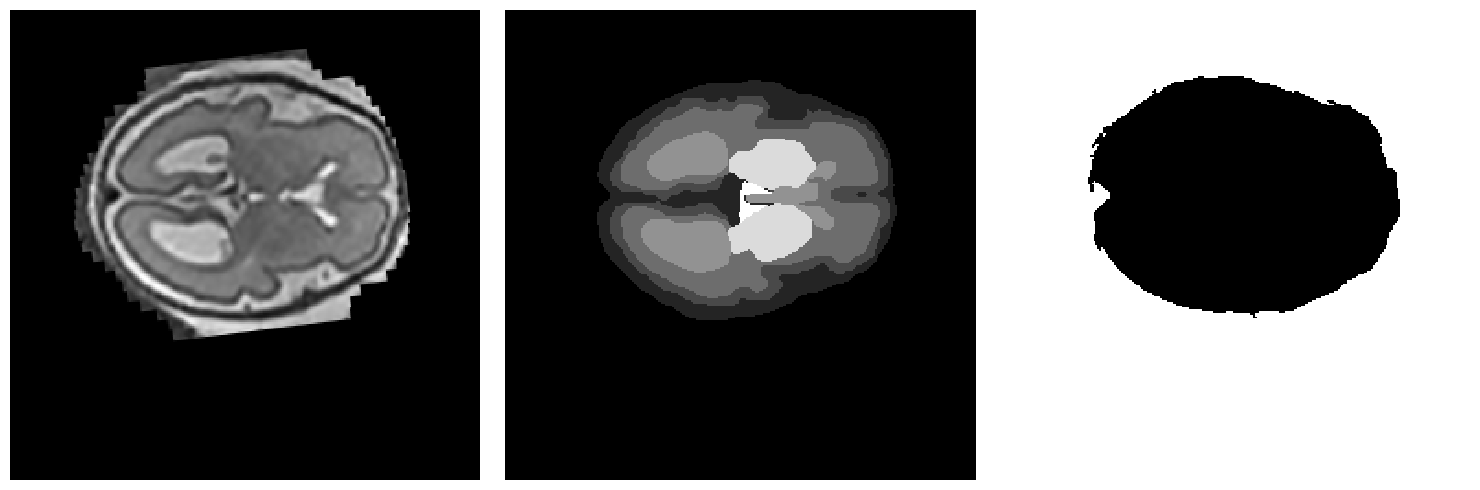

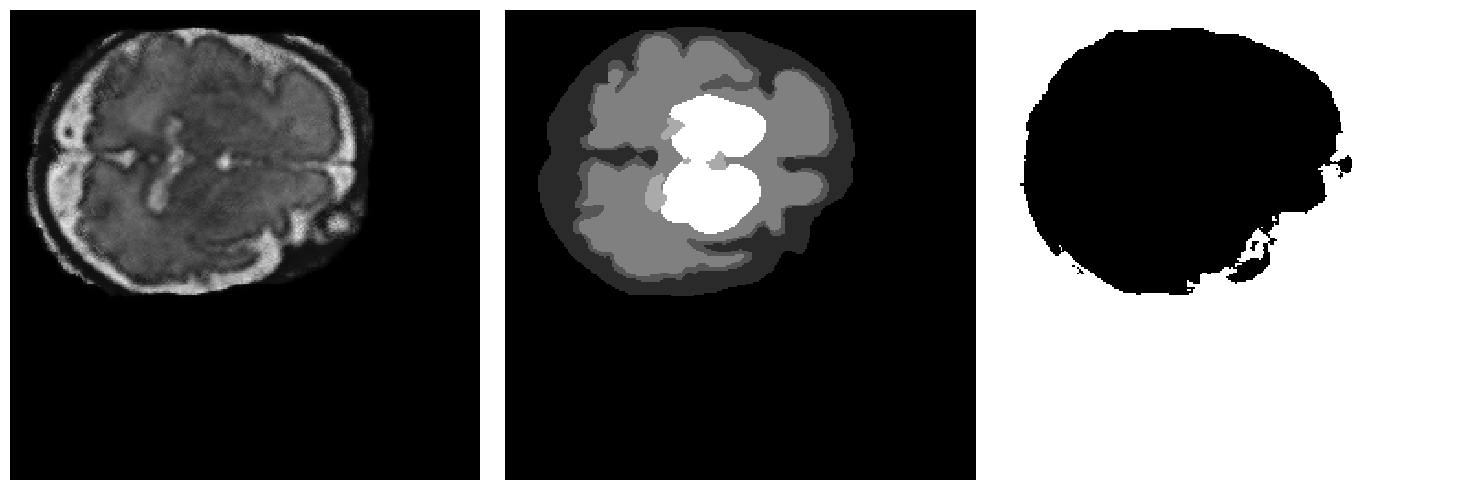

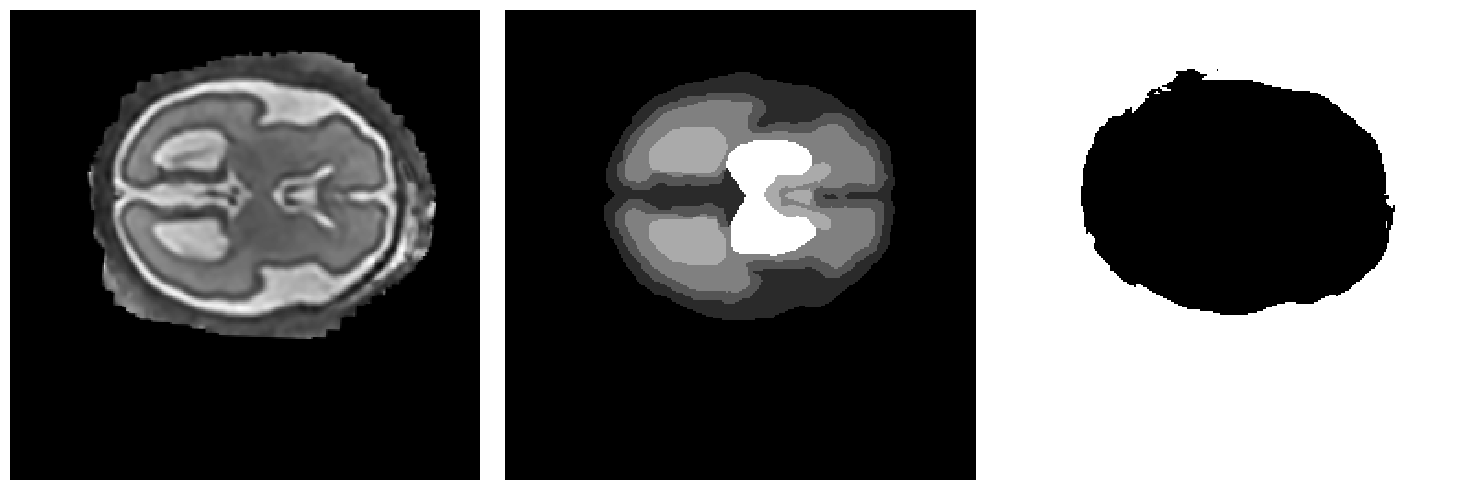

In [45]:
y_preds=[]
# Calculate Dice coefficient for the testing set
for i in range(len(X_test)):
    real_img = X_test[i]
    seg_img = y_test[i]

    real_img = tf.expand_dims(real_img, axis=-1)  # Shape becomes (1, dimx, dimy, 1)
    # print(real_img.shape)
    y_pred = unet_model.predict(real_img, verbose=0)

    y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
    y_preds.append(y_pred)
    test_dice = dice_coefficient(seg_img, y_pred)
    test_dice_coefficients.append(test_dice)

# Calculate the average Dice coefficients for training and testing sets
average_train_dice = np.mean(train_dice_coefficients)
average_test_dice = np.mean(test_dice_coefficients)

# print(f"Average Dice coefficient for the training set: {average_train_dice}")
# print(f"Average Dice coefficient for the testing set: {average_test_dice}")

for i in range(3):
    ne.plot.slices(slices_in=(X_test[i], y_test[i], y_preds[i]), cmaps=['gray', 'gray', 'gray'])

In [2]:
# num_shapes = 20
# num_rows = 4
# num_cols = 5

# combined_images=[]
# combined_label_maps=[]


    
# ################################
# shapes = [draw_shapes(in_shape, num_labels) for _ in range(num_shapes)]
# shapes = map(np.squeeze, shapes)
# shapes = map(np.uint8, shapes)
# shapes = [f + max(labels) + 1 for f in shapes]
# data_generator = generator(label_maps,shapes)#, batch_size=1, same_subj=False, flip=False,**kwargs_shapes)
# num_iterations = num_shapes  # Set the number of iterations as needed
# ################################

# for i in range(num_iterations):
#     gg = next(data_generator)
#     combined_label_maps.append(gg)




# combined_images = []
# combined_images0 = []
# combined_images1 = []

# combined_maps=[]
# y_preds0=[]
# y_preds1=[]

# y_preds=[]
# test_dice_coefficients = []

# for lm in combined_label_maps:
#     lm = np.expand_dims(lm, axis=-1)
#     im, label_map = labels_to_image_model.predict(lm)    
#     y_pred = unet_model.predict(im, verbose=0)

#     y_preds0.append(y_pred[:,:,:,0])
#     y_preds1.append(y_pred[:,:,:,1])

#     y_preds.append(np.argmax(y_pred, axis=-1))
#     combined_images0.append(label_map[:,:,:,0])   
#     combined_images1.append(label_map[:,:,:,1])   

    
#     # y_pred=np.argmax(y_pred, axis=-1)
#     print(label_map.shape,y_pred.shape)
#     test_dice = soft_dice(label_map, y_pred)
#     test_dice_coefficients.append(test_dice)

#     combined_images.append(np.squeeze(im, -1))   

# average_test_dice = np.mean(test_dice_coefficients)
# print(f"Average Dice coefficient for the test set: {average_test_dice}")
 
# image_rows = [combined_images[i:i+num_cols] for i in range(0, len(combined_images), num_cols)]
# image_rows0 = [combined_images0[i:i+num_cols] for i in range(0, len(combined_images), num_cols)]
# image_rows1 = [combined_images1[i:i+num_cols] for i in range(0, len(combined_images), num_cols)]

# preds_rows = [y_preds[i:i+num_cols] for i in range(0, len(y_preds), num_cols)]
# preds_rows0 = [y_preds0[i:i+num_cols] for i in range(0, len(y_preds), num_cols)]
# preds_rows1 = [y_preds1[i:i+num_cols] for i in range(0, len(y_preds), num_cols)]


# for i in range(len(image_rows)):
#     # map_row = maps_rows[i]
#     im_row = image_rows[i]
#     im_row0 = image_rows0[i]
#     im_row1 = image_rows1[i]

#     pred_row = preds_rows[i]
#     pred_row0 = preds_rows0[i]
#     pred_row1 = preds_rows1[i]
    
#     ne.plot.slices([list(shape) for shape in im_row], cmaps=['gray'] * num_cols)
#     ne.plot.slices([list(shape) for shape in im_row0], cmaps=['gray'] * num_cols)
#     # ne.plot.slices([list(shape) for shape in im_row1], cmaps=['gray'] * num_cols)

#     ne.plot.slices([list(pred) for pred in pred_row], cmaps=['gray'] * num_cols)
#     # ne.plot.slices([list(pred) for pred in pred_row0], cmaps=['gray'] * num_cols)
#     # ne.plot.slices([list(pred) for pred in pred_row1], cmaps=['gray'] * num_cols)

# unet_model.summary()

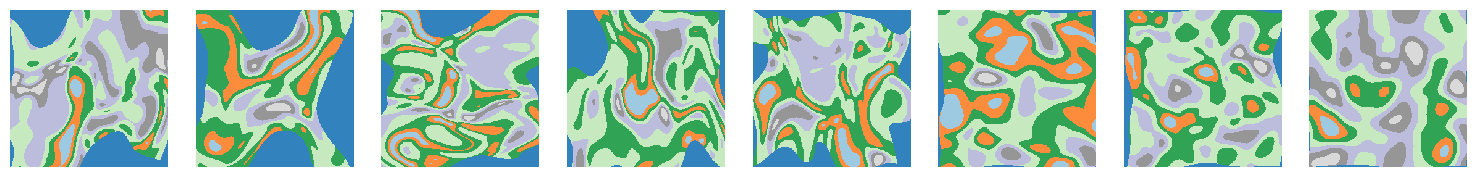

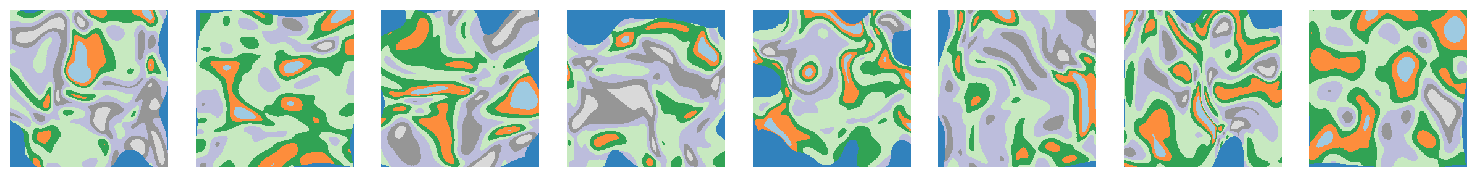

In [3]:
num_row = 2
per_row = 8
################################
shapes = [draw_shapes(in_shape, num_labels) for _ in range(num_shapes)]
shapes = map(np.squeeze, shapes)
shapes = map(np.uint8, shapes)
shapes = [f + max(labels) + 1 for f in shapes]
data_generator = generator(label_maps,shapes)#, batch_size=1, same_subj=False, flip=False,**kwargs_shapes)
################################

for i in range(0, num_row * per_row, per_row):
    ne.plot.slices(shapes[i:i + per_row], cmaps=['tab20c'])

False
False
False
False
1/1 [==============================] - 0s 113ms/step


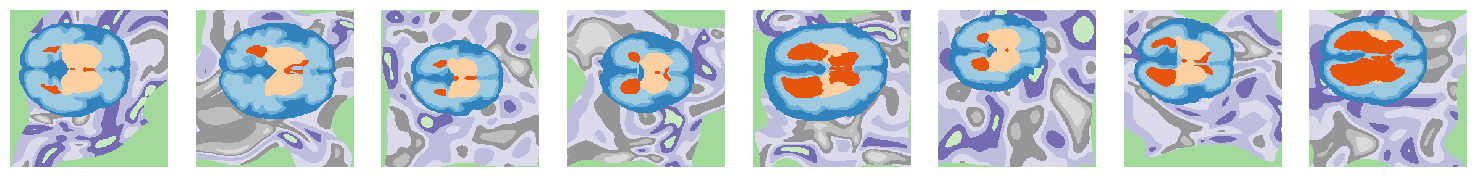

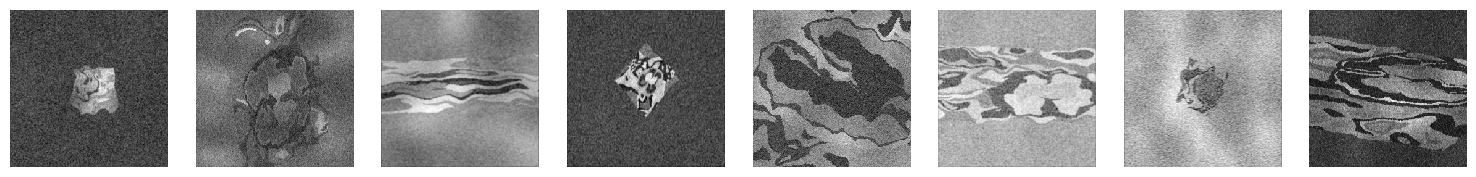

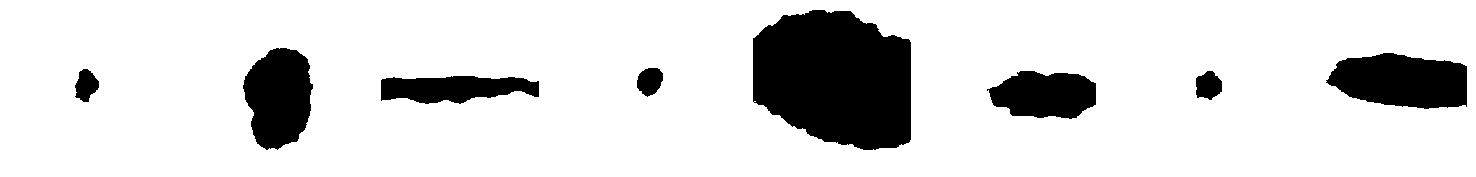

1/1 [==============================] - 0s 129ms/step


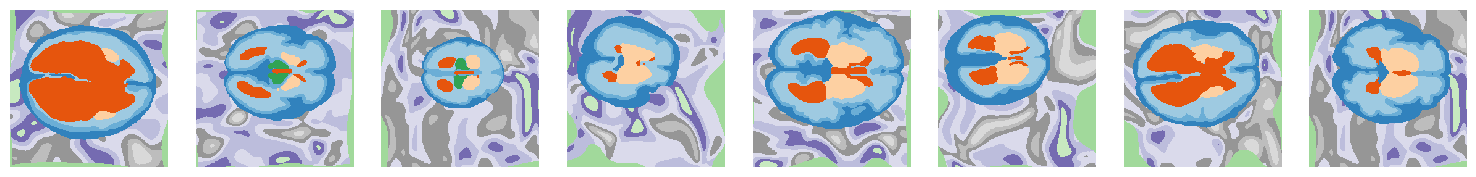

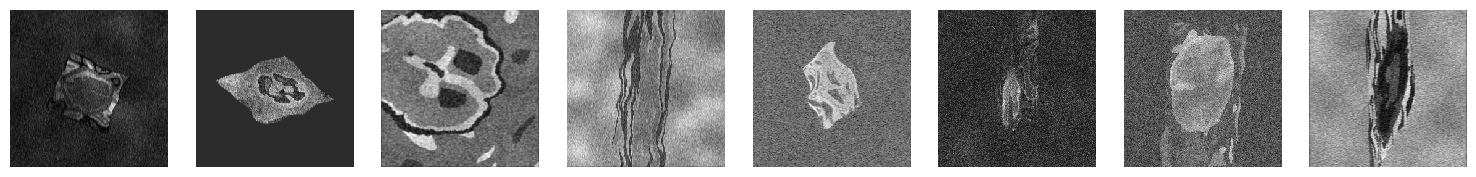

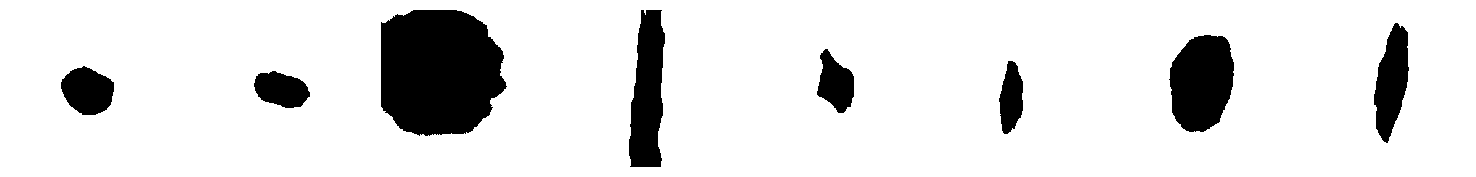

In [8]:
num_row = 2
per_row = 8

def process_label_map(label_map, labels_to_image_model, unet_model):
    lm = np.expand_dims(label_map, axis=-1)
    im, zz = labels_to_image_model.predict(lm)
    predictions = unet_model.predict(im, verbose=0)
    predictions_argmax = np.argmax(predictions, axis=-1)
    zz = np.argmax(zz, axis=-1)

    return im, zz#predictions_argmax
    
for i in range(0, num_row * per_row, per_row):
    slices = [next(data_generator) for _ in range(per_row)]
    images, predictions = zip(*[process_label_map(lm, labels_to_image_model, unet_model) for lm in slices])
    # print(predictions[0].shape)
    ne.plot.slices(slices, cmaps=['tab20c'])
    ne.plot.slices(images, cmaps=['gray'])
    ne.plot.slices(predictions, cmaps=['gray'])

In [3]:
dimx=192
dimy=192
dimz=192
from utils import *
import pathlib
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib

feta = pathlib.Path('/autofs/space/bal_004/users/jd1677/synthstrip/feta_2.1')
files = list(feta.glob('sub-???/anat/sub-???_rec-mial_dseg.nii.gz'))
label_maps = [np.uint8(f.dataobj) for f in map(nib.load, files)]
label_maps = crop_img(label_maps,dimx,dimy,dimz)
labels = np.unique(label_maps)
in_shape = label_maps[0].shape

In [3]:
params = {
    'shift': None,
    'rot': None,
    'scale':5,
    'up_scale': False,  # Set this to True or False for testing
    'shear': None,
    'normal_shift': False,
    'normal_rot': False,
    'normal_scale': False,
    'normal_shear': False,
    'shift_scale': True,
    'ndims': 3,
    'batch_shape': None,
    'concat': True,
    'dtype': tf.float32,
    'seeds': {},
}
max_scaling_factors = []

for _ in range(100):
    outs = vxm.utils.draw_affine_params(**params)
    scaling_factor = outs[6:9]
    max_scaling_factor = np.max((scaling_factor.numpy()))
    max_scaling_factors.append(max_scaling_factor)

    print(f" {_ + 1}:  max: {max_scaling_factor}")

min_max_scaling_factor = np.max(max_scaling_factors)
print(f"Minimum of maximum absolute scaling factors: {min_max_scaling_factor}")

 1:  max: -1.2906806468963623
 2:  max: 1.7292041778564453
 3:  max: -1.237962245941162
 4:  max: 0.8882560729980469
 5:  max: 0.8448076248168945
 6:  max: 1.4267911911010742
 7:  max: -0.6877713203430176
 8:  max: 1.9868512153625488
 9:  max: 1.980628490447998
 10:  max: 0.4578073024749756
 11:  max: 1.7116708755493164
 12:  max: 1.3148751258850098
 13:  max: 1.4987397193908691
 14:  max: 1.9999423027038574
 15:  max: 0.7363672256469727
 16:  max: 1.7620019912719727
 17:  max: 0.4719400405883789
 18:  max: 1.190110206604004
 19:  max: 0.2954554557800293
 20:  max: -0.05761909484863281
 21:  max: -1.784557580947876
 22:  max: 1.3769936561584473
 23:  max: 0.9550864696502686
 24:  max: 1.884812831878662
 25:  max: 1.084765911102295
 26:  max: 1.0880870819091797
 27:  max: 0.8533735275268555
 28:  max: 0.7350172996520996
 29:  max: -0.04763531684875488
 30:  max: 1.5356101989746094
 31:  max: 1.548022747039795
 32:  max: -0.2534756660461426
 33:  max: 0.3635365962982178
 34:  max: -0.102

In [21]:
print(affine_params.shape)

tf.Tensor(
[ 0.          0.          0.          0.          0.          0.
 -0.15583861 -0.34321105 -0.15547347  0.          0.          0.        ], shape=(12,), dtype=float32)


In [2]:
import tensorflow.keras.layers as KL
import voxelmorph as vxm
from utils import *
import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
import surfa as sf

mgh = pathlib.Path('fetus_label_map')
mgh_files = list(mgh.glob('*.nii.gz'))

#label_maps = [np.uint8(f.dataobj) for f in map(nib.load, files)]

# label_maps = [np.uint8(sf.load_volume(str(file_path)).reshape((dimx, dimy, dimz)).data) for file_path in files]
label_maps = [np.uint8(sf.load_volume(str(file_path)).data) for file_path in mgh_files]

2024-01-18 20:51:36.199939: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-18 20:51:36.260885: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Issue loading cv2


In [3]:
label_maps[0].shape

(256, 256, 256)